In [1]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
from PIL import ImageFilter, Image
#from matplotlib import pylab as plt
import matplotlib.pyplot as plt
import pickle
import tensorflow.contrib.slim as slim
from tensorflow.contrib.framework import get_or_create_global_step

# From https://github.com/tensorflow/models/tree/master/slim.
#from models.slim.nets import inception_v3
from tensorflow.contrib.slim.nets import inception

import os, time

# From our repository.
#from saliency import SaliencyMask
#from saliency import GradientSaliency
#from guided_backprop import GuidedBackprop
#from integrated_gradients import IntegratedGradients
#from occlusion import Occlusion
#import visualization

%matplotlib inline

In [2]:
def show_image(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  im = ((im + 1) * 127.5).astype(np.uint8)
  plt.imshow(im)
  plt.title(title)

def load_image(file_path):
  im = Image.open(file_path)
  im = np.asarray(im)
  return im / 127.5 - 1.0

def blur(img, radius = 10):
    img = Image.fromarray(np.uint8((img+1)*127.5))
    blurred_img = img.filter(ImageFilter.GaussianBlur(radius))
    return np.array(blurred_img)/127.5-1

In [3]:
#!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
#!tar -xvzf inception_v3_2016_08_28.tar.gz

In [35]:
graph = tf.Graph()
tf_global_step = get_or_create_global_step()

with graph.as_default():
    images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3), name='images')
    null_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3), name='null_images')
    mask = tf.get_variable("mask", shape=(32,32,1), initializer=tf.random_uniform_initializer(0,1))#tf.zeros_initializer())  
    mask_up = tf.image.resize_images(mask,(299,299))
    inputs = images * mask_up + null_images * (1 - mask_up)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(inputs, is_training=False, num_classes=1001)

        # Remove mask variable from list of variables to restore
        var_list = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if "mask" not in v.name]
        #var_list = None
        
        # Restore the checkpoint
        sess = tf.Session(graph=graph)
        saver = tf.train.Saver(var_list = var_list)
        saver.restore(sess, './inception_v3.ckpt')
        
    # Construct the scalar neuron tensor.
    logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
    neuron_selector = tf.placeholder(tf.int32, name='neuron_selector')
    y = logits[0][neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits, 1)

INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


In [36]:
clean_dir = '/Users/ruthfong/tensorflow/cleverhans/examples/nips17_adversarial_competition/dataset/images'
adv_dir = '/Users/ruthfong/tensorflow/cleverhans/examples/nips17_adversarial_competition/sample_attacks/fgsm/output_16'

In [37]:
labels = np.loadtxt('/Users/ruthfong/ilsvrc12/synset_words.txt', delimiter='\n', dtype=str)

Prediction class: n04069434 reflex camera (759)


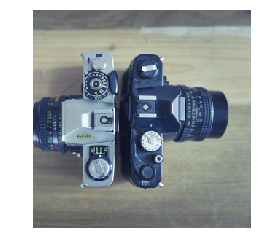

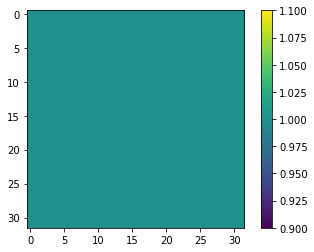

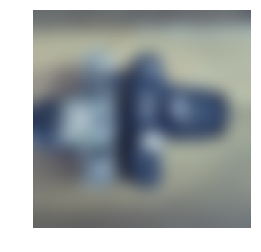

In [38]:
# Load the image
use_clean = True

img_dir = clean_dir if use_clean else adv_dir
im = load_image(os.path.join(img_dir, '0f9d8c86a9f38020.png'))
#im = load_image('/Users/ruthfong/tensorflow/saliency/doberman.png')
#with graph.as_default():
#    with sess.as_default():
#        tf.global_variables_initializer().run()

sess.run(mask.initializer)

assign_op = tf.assign(mask, tf.ones_like(mask))
sess.run(assign_op)

#prediction_class = sess.run(prediction, feed_dict = {images: [im]})
(m, comb_img, prediction_class) = sess.run([mask, inputs, prediction], feed_dict = {images: [im], 
                                                                                    null_images: [blur(im, 10)]})
m = np.squeeze(m)
comb_img = comb_img[0]
top_predicted_class = prediction_class[0]

print("Prediction class: %s (%d)" % (labels[top_predicted_class-1], top_predicted_class-1))  # Should be a doberman, class idx = 237

show_image(comb_img)

f, ax = plt.subplots(1,1)
cax = ax.imshow(m)
f.colorbar(cax)
plt.show()

show_image(blur(im, 10))

51.0933 ['n02927161 butcher shop, meat market']


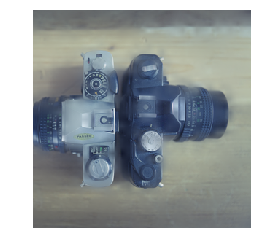

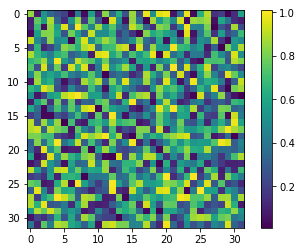

46.1084 ['n04033995 quilt, comforter, comfort, puff']


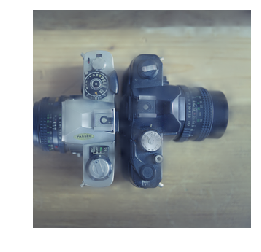

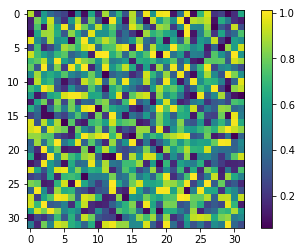

41.3796 ['n04033995 quilt, comforter, comfort, puff']


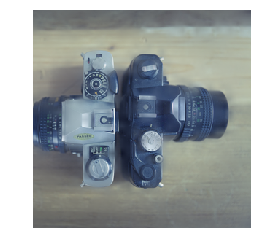

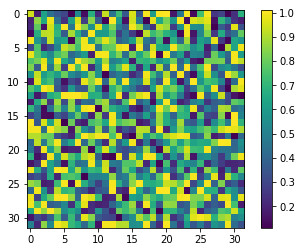

36.8919 ['n04033995 quilt, comforter, comfort, puff']


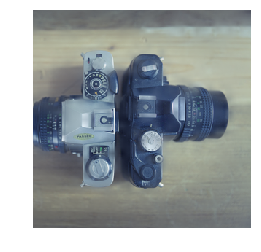

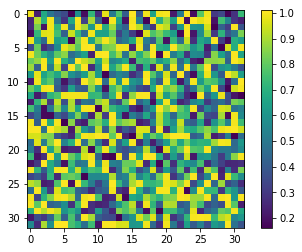

32.6876 ['n02927161 butcher shop, meat market']


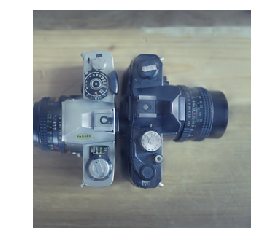

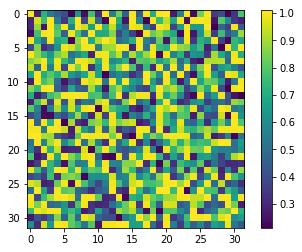

28.7447 ['n02927161 butcher shop, meat market']


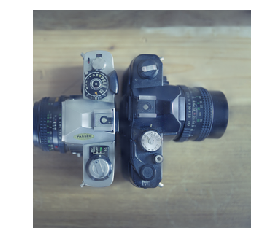

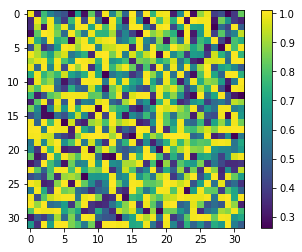

25.0395 ['n02927161 butcher shop, meat market']


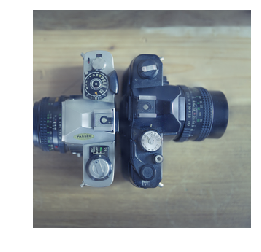

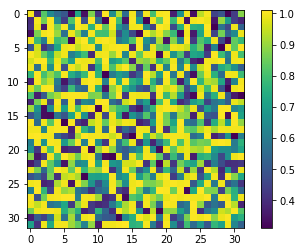

KeyboardInterrupt: 

In [40]:
with graph.as_default():
    l1_lambda = tf.placeholder(tf.float32, name='l1_lambda')
    tv_lambda = tf.placeholder(tf.float32, name='tv_lambda')
    tv_beta = tf.placeholder(tf.float32, name='tv_beta')

    softmax = end_points['Predictions']
    score_loss = softmax[0][neuron_selector]
    l1_loss = tf.reduce_sum(tf.abs(1-mask))
    def tv_norm(x, beta):
        x = x[:,:,0]
        dy = tf.reduce_mean(tf.pow(tf.abs(x[:-1,:]-x[1:,:]),beta))
        dx = tf.reduce_mean(tf.pow(tf.abs(x[:,:-1]-x[:,1:]),beta))
        return dy+dx

    tot_loss = score_loss + l1_lambda * l1_loss + tv_lambda * tv_norm(mask, tv_beta)
    
    optimizer = tf.train.GradientDescentOptimizer(0.1)
    train = optimizer.minimize(tot_loss)
    
    sess.run(mask.initializer)

    for i in range(300):
        (t_loss, m, comb_img, prediction_class, _) = sess.run([tot_loss, mask, inputs, prediction,train], 
                                                                 feed_dict={l1_lambda: 0.1,
                                                                            tv_lambda: 0.2, 
                                                                            tv_beta: 3., 
                                                                            neuron_selector: top_predicted_class, 
                                                                            images: [im], 
                                                                            null_images: [blur(im, 10)]})
        
        if i % 5 == 0:
            print t_loss, labels[prediction_class-1]
            
            m = np.squeeze(m)
            comb_img = comb_img[0]
            prediction_class = prediction_class[0]
            
            show_image(comb_img)

            f, ax = plt.subplots(1,1)
            cax = ax.imshow(m)
            f.colorbar(cax)
            plt.show()

In [58]:
for op in graph.get_operations():
    if op.type == 'Placeholder':
        print op.name

images
null_images
Placeholder
l1_lambda
tv_lambda
tv_beta


In [ ]:
with graph.as_default():
    global_step = tf.train.get_global_step()
    

In [81]:
with graph.as_default():
    gradients_node = tf.gradients(y, images)[0]

In [87]:
with graph.as_default():
    mask = tf.get_variable("mask", shape=(32,32,1), initializer=tf.zeros_initializer())

In [88]:
with graph.as_default():
    mask_upsampled=tf.image.resize_images(mask,(299,299))

In [89]:
with graph.as_default():
    with sess.as_default():
        tf.global_variables_initializer().run()

In [90]:
mask_upsampled

<tf.Tensor 'Squeeze:0' shape=(299, 299, 1) dtype=float32>

In [91]:
null_im = blur(im,10)

In [92]:
comb_im = mask_upsampled * im + (1 - mask_upsampled) * null_im

In [97]:
(grad, pred) = sess.run([gradients_node, prediction], feed_dict = {images: [comb_im.eval(session=sess)], 
                                                             neuron_selector: prediction_class})

In [103]:
mask = tf.clip_by_value(mask,0,1)

In [127]:
for n in graph.as_graph_def().node:
    print n.name

x
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/shape
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mean
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/stddev
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/TruncatedNormal
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mul
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal
InceptionV3/Conv2d_1a_3x3/weights
InceptionV3/Conv2d_1a_3x3/weights/Assign
InceptionV3/Conv2d_1a_3x3/weights/read
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/scale
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/L2Loss
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/Shape
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/dilation_rate
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution
InceptionV3/Conv2d_1a_3x3/BatchNorm/beta/Initializer/zeros
InceptionV

InceptionV3/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/kernel/Regularizer/l2_regularizer/scale
InceptionV3/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/kernel/Regularizer/l2_regularizer/L2Loss
InceptionV3/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/kernel/Regularizer/l2_regularizer
InceptionV3/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/convolution/Shape
InceptionV3/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/convolution/dilation_rate
InceptionV3/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/convolution
InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta/Initializer/zeros
InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta/Assign
InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta/read
InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean/Initializer/zeros
InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean/Assign
Ince

InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights
InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights/Assign
InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights/read
InceptionV3/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/kernel/Regularizer/l2_regularizer/scale
InceptionV3/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/kernel/Regularizer/l2_regularizer/L2Loss
InceptionV3/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/kernel/Regularizer/l2_regularizer
InceptionV3/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/convolution/Shape
InceptionV3/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/convolution/dilation_rate
InceptionV3/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/convolution
InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/beta/Initializer/zeros
InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/beta
InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/beta/Assign
InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/beta/read
InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/movin

save/RestoreV2_126/shape_and_slices
save/RestoreV2_126
save/Assign_126
save/RestoreV2_127/tensor_names
save/RestoreV2_127/shape_and_slices
save/RestoreV2_127
save/Assign_127
save/RestoreV2_128/tensor_names
save/RestoreV2_128/shape_and_slices
save/RestoreV2_128
save/Assign_128
save/RestoreV2_129/tensor_names
save/RestoreV2_129/shape_and_slices
save/RestoreV2_129
save/Assign_129
save/RestoreV2_130/tensor_names
save/RestoreV2_130/shape_and_slices
save/RestoreV2_130
save/Assign_130
save/RestoreV2_131/tensor_names
save/RestoreV2_131/shape_and_slices
save/RestoreV2_131
save/Assign_131
save/RestoreV2_132/tensor_names
save/RestoreV2_132/shape_and_slices
save/RestoreV2_132
save/Assign_132
save/RestoreV2_133/tensor_names
save/RestoreV2_133/shape_and_slices
save/RestoreV2_133
save/Assign_133
save/RestoreV2_134/tensor_names
save/RestoreV2_134/shape_and_slices
save/RestoreV2_134
save/Assign_134
save/RestoreV2_135/tensor_names
save/RestoreV2_135/shape_and_slices
save/RestoreV2_135
save/Assign_135
sa

save/RestoreV2_386
save/Assign_386
save/RestoreV2_387/tensor_names
save/RestoreV2_387/shape_and_slices
save/RestoreV2_387
save/Assign_387
save/restore_all


In [104]:
for op in graph.get_operations():
    print str(op.name)

Placeholder
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/shape
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mean
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/stddev
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/TruncatedNormal
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal/mul
InceptionV3/Conv2d_1a_3x3/weights/Initializer/truncated_normal
InceptionV3/Conv2d_1a_3x3/weights
InceptionV3/Conv2d_1a_3x3/weights/Assign
InceptionV3/Conv2d_1a_3x3/weights/read
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/scale
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer/L2Loss
InceptionV3/InceptionV3/Conv2d_1a_3x3/kernel/Regularizer/l2_regularizer
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/Shape
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution/dilation_rate
InceptionV3/InceptionV3/Conv2d_1a_3x3/convolution
InceptionV3/Conv2d_1a_3x3/BatchNorm/beta/Initializer/zeros


InceptionV3/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/kernel/Regularizer/l2_regularizer/L2Loss
InceptionV3/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/kernel/Regularizer/l2_regularizer
InceptionV3/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/convolution/Shape
InceptionV3/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/convolution/dilation_rate
InceptionV3/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/convolution
InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta/Initializer/zeros
InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta/Assign
InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta/read
InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean/Initializer/zeros
InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean/Assign
InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean/read
InceptionV3/Mixed_6b/Branch_1

InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/beta/Assign
InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/beta/read
InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean/Initializer/zeros
InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean/Assign
InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean/read
InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance/Initializer/ones
InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance/Assign
InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance/read
InceptionV3/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add/y
InceptionV3/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add
InceptionV3/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/Rsqrt
InceptionV3/InceptionV3

InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta/Assign
InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta/read
InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean/Initializer/zeros
InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean/Assign
InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean/read
InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance/Initializer/ones
InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance/Assign
InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance/read
InceptionV3/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/batchnorm/add/y
InceptionV3/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/batchnorm/add
InceptionV3/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/batchnorm/Rsqrt
InceptionV3/InceptionV3

save/RestoreV2_115
save/Assign_115
save/RestoreV2_116/tensor_names
save/RestoreV2_116/shape_and_slices
save/RestoreV2_116
save/Assign_116
save/RestoreV2_117/tensor_names
save/RestoreV2_117/shape_and_slices
save/RestoreV2_117
save/Assign_117
save/RestoreV2_118/tensor_names
save/RestoreV2_118/shape_and_slices
save/RestoreV2_118
save/Assign_118
save/RestoreV2_119/tensor_names
save/RestoreV2_119/shape_and_slices
save/RestoreV2_119
save/Assign_119
save/RestoreV2_120/tensor_names
save/RestoreV2_120/shape_and_slices
save/RestoreV2_120
save/Assign_120
save/RestoreV2_121/tensor_names
save/RestoreV2_121/shape_and_slices
save/RestoreV2_121
save/Assign_121
save/RestoreV2_122/tensor_names
save/RestoreV2_122/shape_and_slices
save/RestoreV2_122
save/Assign_122
save/RestoreV2_123/tensor_names
save/RestoreV2_123/shape_and_slices
save/RestoreV2_123
save/Assign_123
save/RestoreV2_124/tensor_names
save/RestoreV2_124/shape_and_slices
save/RestoreV2_124
save/Assign_124
save/RestoreV2_125/tensor_names
save/R

save/Assign_313
save/RestoreV2_314/tensor_names
save/RestoreV2_314/shape_and_slices
save/RestoreV2_314
save/Assign_314
save/RestoreV2_315/tensor_names
save/RestoreV2_315/shape_and_slices
save/RestoreV2_315
save/Assign_315
save/RestoreV2_316/tensor_names
save/RestoreV2_316/shape_and_slices
save/RestoreV2_316
save/Assign_316
save/RestoreV2_317/tensor_names
save/RestoreV2_317/shape_and_slices
save/RestoreV2_317
save/Assign_317
save/RestoreV2_318/tensor_names
save/RestoreV2_318/shape_and_slices
save/RestoreV2_318
save/Assign_318
save/RestoreV2_319/tensor_names
save/RestoreV2_319/shape_and_slices
save/RestoreV2_319
save/Assign_319
save/RestoreV2_320/tensor_names
save/RestoreV2_320/shape_and_slices
save/RestoreV2_320
save/Assign_320
save/RestoreV2_321/tensor_names
save/RestoreV2_321/shape_and_slices
save/RestoreV2_321
save/Assign_321
save/RestoreV2_322/tensor_names
save/RestoreV2_322/shape_and_slices
save/RestoreV2_322
save/Assign_322
save/RestoreV2_323/tensor_names
save/RestoreV2_323/shape_

gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/Relu_grad/ReluGrad
gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Shape
gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Shape_1
gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/BroadcastGradientArgs
gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Sum
gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Reshape
gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Sum_1
gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Reshape_1
gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/batchnorm/add_1_grad/Shape
gradients/InceptionV3/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/Bat

gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/convolution_grad/Conv2DBackpropFilter
gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/Relu_grad/ReluGrad
gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Shape
gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Shape_1
gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/BroadcastGradientArgs
gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Sum
gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Reshape
gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Sum_1
gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Reshape_1
gradients/InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/Ba

gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/convolution_grad/Shape_1
gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/convolution_grad/Conv2DBackpropFilter
gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/Relu_grad/ReluGrad
gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Shape
gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Shape_1
gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/BroadcastGradientArgs
gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Sum
gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Reshape
gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Sum_1
gradients/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/batchnor

gradients_1/InceptionV3/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Shape_1
gradients_1/InceptionV3/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/BroadcastGradientArgs
gradients_1/InceptionV3/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Sum
gradients_1/InceptionV3/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Reshape
gradients_1/InceptionV3/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Sum_1
gradients_1/InceptionV3/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/batchnorm/add_1_grad/Reshape_1
gradients_1/InceptionV3/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/batchnorm/add_1_grad/Shape
gradients_1/InceptionV3/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/batchnorm/add_1_grad/Shape_1
gradients_1/InceptionV3/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/batchnorm/add_1_grad/BroadcastGradientArgs
gradients_1/Inc

gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/batchnorm/mul_grad/Sum_1
gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/batchnorm/mul_grad/Reshape_1
gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_1/Conv2d_0a_1x1/convolution_grad/Shape
gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_1/Conv2d_0a_1x1/convolution_grad/Conv2DBackpropInput
gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_1/Conv2d_0a_1x1/convolution_grad/Shape_1
gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_1/Conv2d_0a_1x1/convolution_grad/Conv2DBackpropFilter
gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/convolution_grad/Shape
gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/convolution_grad/Conv2DBackpropInput
gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/convolution_grad/Shape_1
gradients_1/InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/convolution_grad/Conv2DBackpropFilter
